# Custom Datasets

| Topic                                             | Contents                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|---------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0. Importing PyTorch and setting up device-agnostic code | We will import PyTorch and set up our code to be device-agnostic following best practices.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 1. Get data                                        | We will use our custom dataset of pizza, steak, and sushi images.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| 2. Become one with the data (data preparation)     | Understanding the data is crucial in any machine learning problem. In this section, we will take steps to figure out what data we have.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 3. Transforming data                               | Data may not always be ready to use with a machine learning model. In this section, we will look at some steps we can take to transform our images to prepare them for use with a model.                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 4. Loading data with ImageFolder (option 1)        | PyTorch has many in-built data loading functions for common types of data. In this section, we will use the ImageFolder function, which is helpful when images are in standard image classification format.                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 5. Loading image data with a custom Dataset        | What if PyTorch doesn't have a built-in function to load data with? In this section, we will build our own custom subclass of torch.utils.data.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 6. Other forms of transforms (data augmentation)   | Data augmentation is a common technique for expanding the diversity of your training data. In this section, we will explore some of torchvision's built-in data augmentation functions.                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 7. Model 0: TinyVGG without data augmentation      | In this section, we will build a model capable of fitting our data, and create some training and testing functions for training and evaluating our model.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 8. Exploring loss curves                           | Loss curves are a great way to see how your model is training/improving over time. In this section, we will use them to assess our model's performance and determine whether it is overfitting or underfitting.                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 9. Model 1: TinyVGG with data augmentation         | We will build another model using data augmentation to see if it improves our model's performance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 10. Compare model results                          | We will compare the loss curves of our different models and determine which performed better, discussing options for improving performance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 11. Making a prediction on a custom image          | In this section, we will use our trained model to predict on an image outside of our existing dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |

## 0. Preparation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Load data

In [3]:
from pathlib import Path

image_path = Path('data/pizza_steak_sushi/')
train_path = image_path / 'train'
test_path = image_path / 'test'

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

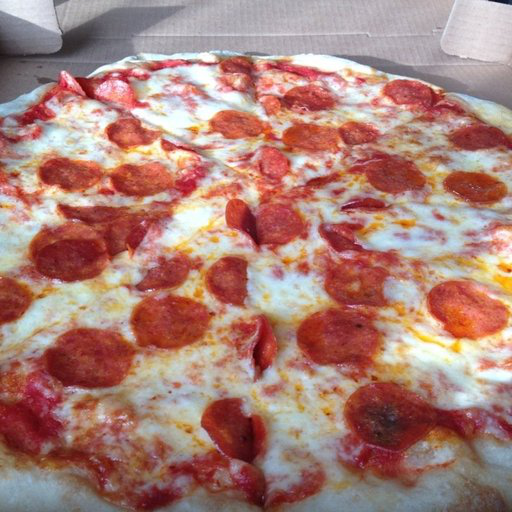

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

img

## 2. Transforming data

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets as D, transforms as T

data_transforms = T.Compose([
    T.Resize(size=(64, 64)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [6]:
train_data = D.ImageFolder(root=train_path, transform=data_transforms)

test_data = D.ImageFolder(root=test_path, transform=data_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [7]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [8]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [9]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [10]:
img, label = train_data[0][0], train_data[0][1]

img.shape, img.dtype, class_names[label]

(torch.Size([3, 64, 64]), torch.float32, 'pizza')

### DataLoader

In [11]:
import os

# Turn train and test Datasets into DataLoaders
batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=False) # don't usually need to shuffle testing data

## 3. Build a TinyVGG model

In [12]:
class TinyVGG(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=out_shape),                      
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(in_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_shape=len(train_data.classes))
model_0.to(device)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [14]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.2929,  0.0430, -0.2125]], device='cuda:0')

Output prediction probabilities:
tensor([[0.2871, 0.4017, 0.3112]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


### Sumary

In [15]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

/home/ht0710/miniconda3/envs/torch/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/ht0710/miniconda3/envs/torch/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Training loop

In [16]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [19]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

# Set number of epochs
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_step(model_0, train_dataloader, criterion, optimizer)

    test_loss, test_acc = test_step(model_0, test_dataloader, criterion)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    if (epoch+1) % 1 == 0:
        print(f"\nEpoch: {epoch+1}\n----------")
        print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")



Epoch: 1
----------
Train loss: 1.1147, accuracy: 0.2930 | Test loss: 1.0977, accuracy: 0.1979

Epoch: 2
----------
Train loss: 1.0993, accuracy: 0.2539 | Test loss: 1.0721, accuracy: 0.5417

Epoch: 3
----------
Train loss: 1.0969, accuracy: 0.2812 | Test loss: 1.0661, accuracy: 0.5417

Epoch: 4
----------
Train loss: 1.1183, accuracy: 0.2812 | Test loss: 1.0762, accuracy: 0.5417

Epoch: 5
----------
Train loss: 1.1024, accuracy: 0.2891 | Test loss: 1.1110, accuracy: 0.1979


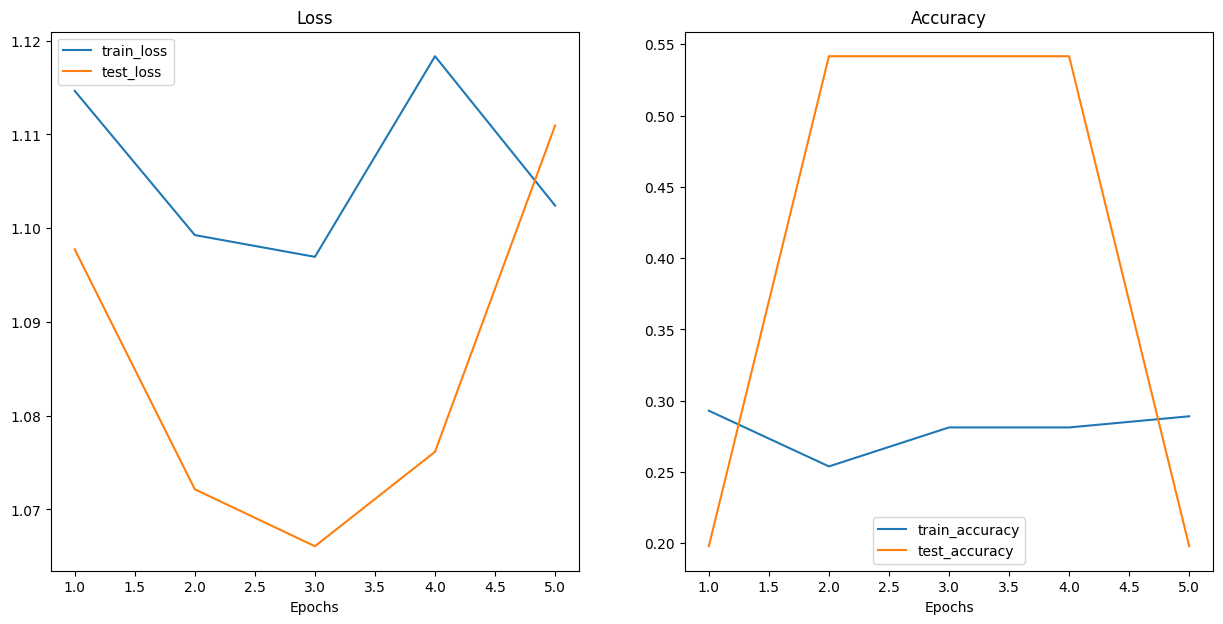

In [20]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    epochs = [x + 1 for x in range(len(results['train_loss']))]

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_loss'], label='train_loss')
    plt.plot(epochs, results['test_loss'], label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results['train_acc'], label='train_accuracy')
    plt.plot(epochs, results['test_acc'], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(results)

## 5. Data Augmentation

In [21]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Create testing transform (no data augmentation)
test_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

In [22]:
# Turn image folders into Datasets
train_data_augmented = D.ImageFolder(train_path, transform=train_transform_trivial_augment)
test_data_simple = D.ImageFolder(test_path, transform=test_transform)

In [23]:
# Turn Datasets into DataLoader's
import os

torch.manual_seed(42)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

In [24]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(
    in_shape=3,
    hidden_units=64,
    out_shape=len(train_data_augmented.classes)).to(device)

In [25]:
# summary(model_1, input_size=[1, 3, 64, 64])

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [27]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

results_1 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

# Set number of epochs
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_step(model_1, train_dataloader, criterion, optimizer)

    test_loss, test_acc = test_step(model_1, test_dataloader, criterion)

    results_1["train_loss"].append(train_loss)
    results_1["train_acc"].append(train_acc)
    results_1["test_loss"].append(test_loss)
    results_1["test_acc"].append(test_acc)
    
    if (epoch+1) % 2 == 0:
        print(f"\nEpoch: {epoch+1} | Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")



Epoch: 2 | Train loss: 1.0903, accuracy: 0.4258 | Test loss: 1.1139, accuracy: 0.2604

Epoch: 4 | Train loss: 1.1016, accuracy: 0.3047 | Test loss: 1.1139, accuracy: 0.2604

Epoch: 6 | Train loss: 1.1013, accuracy: 0.3047 | Test loss: 1.1140, accuracy: 0.2604

Epoch: 8 | Train loss: 1.0901, accuracy: 0.4258 | Test loss: 1.1139, accuracy: 0.2604

Epoch: 10 | Train loss: 1.0902, accuracy: 0.4258 | Test loss: 1.1141, accuracy: 0.2604


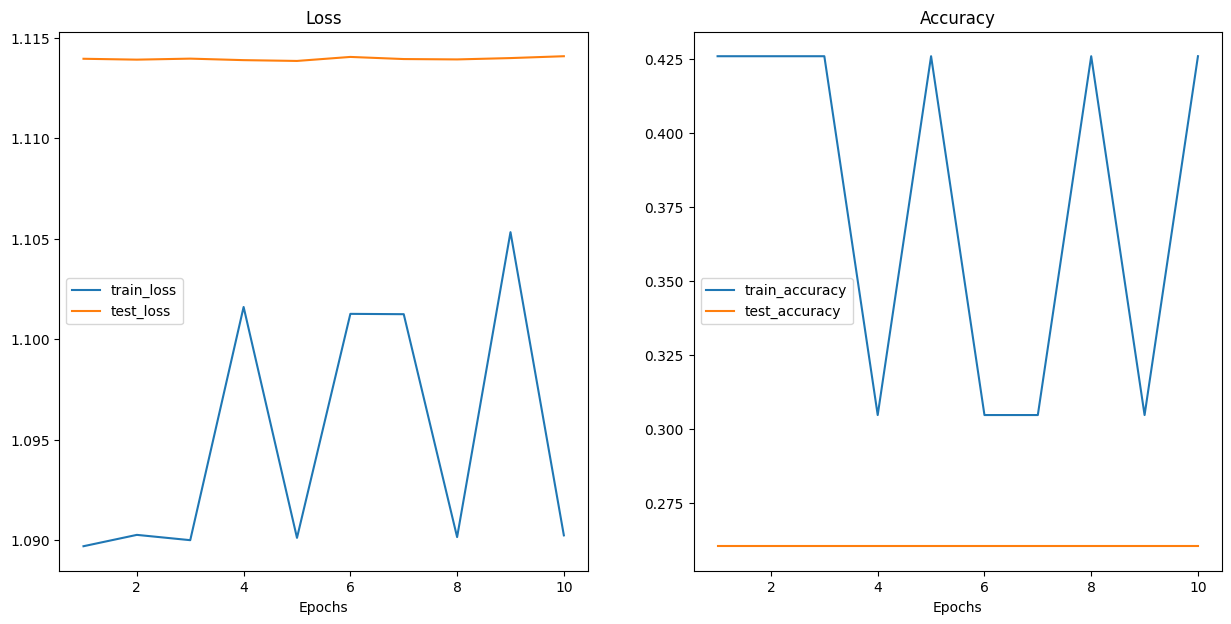

In [28]:
plot_loss_curves(results_1)